In [1]:
import Gauss_Newton as gn
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import sparse

# Initialization

*Gauss_Newton* is the module with all functions made to deal with the problem of tensor low rank approximations. After we import the necessary modules, we start initializing a random tensor $T$, the desired rank $r$ and the relevant parameters. The program will try to find the tensor $S = \sum_{\ell=1}^r \Lambda_\ell \cdot X_\ell \otimes Y_\ell \otimes Z_\ell$ of rank $\leq r$ closest to $T$.

Write $T$ and $S$ in coordinates $T_{ijk}, S_{ijk}$, for $i,j,k = 0 \ldots n$. The notion of distance between two tensors is given by the Frobenius norm
$$\|T-S\| = \sum_{i,j,k=0}^n | T_{ijk} - S_{ijk}|^2,$$
where $S_{ijk} = \sum_{\ell=1}^r \Lambda_\ell X_{\ell_i} Y_{\ell_j} Z_{\ell_k}$.

In [2]:
#Initialize tensor and desired rank.
n = 10
r = 20
T = np.random.randn(n+1,n+1,n+1)
Tsize = np.linalg.norm(T)

#Initialize parameters.
maxtrials = 100
maxit = 100
tol = 5*10**(-4)

By default the parameters *maxit* and *tol* are set to $500$ and $0.001$ respectively, but experiments shows that almost never we need more than $100$ iterations. Also, we choose to pick a slightly smaller *tol* $= 0.0005$ for no specific reason (or just for fun, if you prefer). The choice of the tolerance parameter can change substantially the computation time. We will see this matter later. 

The function *low_rank* will compute at most $100$ different approximations to $T$ and keep the best one. The program stops the computations if $\|T-S\|/\|T\| < tol$ or the improvement of $\|T-S\|/\|T\|$ in some trial is less than *tol*.

In [3]:
#Use the function low_rank to search the best rank r approximation to T.
start = time.time()
[L,X,Y,Z,S,error,step_sizes,errors,xpath,times,steps,rel_errors] = gn.low_rank(T,r,n,maxtrials,maxit,tol)

#After the computations ends we can print some useful information.
print('----------------------------------------\nResults:')
print('Total time =',time.time() - start,'seconds')
print('Total of trials =',steps.shape[0])
Ssize = np.linalg.norm(S)
print('|T| =',Tsize)
print('|S| =',Ssize)
print('|T-S| =',error)
print('|T-S|/|T| =',error/Tsize)

----------------------------------------
Results:
Total time = 117.60140371322632 seconds
Total of trials = 100
|T| = 36.9453976687
|S| = 31.1259849744
|T-S| = 19.0398040138
|T-S|/|T| = 0.515349819336


# Analyzing the results

The function *low_rank* returns several information about the computations made in the proccess of searching for the best approximation. First, the variables $\Lambda,X,Y,Z$ are a compact representations of the tensor $S$. We use them to construct the CPD of $S$. See the file *Gauss_Newton.ipynb* for more details. We have that the *error *$= \|T-S\|$ is the absolute error between $T$ and $S$. Below we give a brief description of each output:

$\bullet$ *step_sizes* is an array with the size step of the point $x$ made at each iteration of the best trial. 

$\bullet$ *errors* is an array with the absolute erros between $T$ and the current computed $S$ at each iteration of the best trial.

$\bullet$ *xpath* is a matrix in which the $i$ th row is the point $x$ computed at the $i$ th iteration of the best trial.

The three arrays above are restricted to the best trial. In this case the program made $100$ trials, which was the maximum number permitted of trials. This means the program couldn't reach the conditions of proximity established by *tol.* 

The last three arrays gives informations about all trials altogether. 

$\bullet$ *times* is an array with the time used to compute each approximation. Since we made $100$ trials, *times* has lenght $100$.

$\bullet$ *steps* is an array with the number of steps (iterations) used to computed each approximation.

$\bullet$ *rel_errors* is an array with the relative error of the approximation at each trial.

First we plot the informations about the best trial.


Plots related to the best approximation



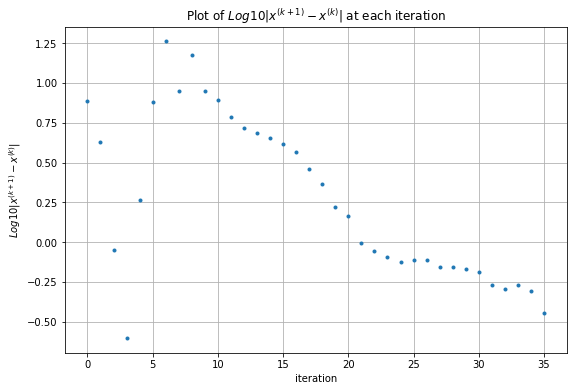

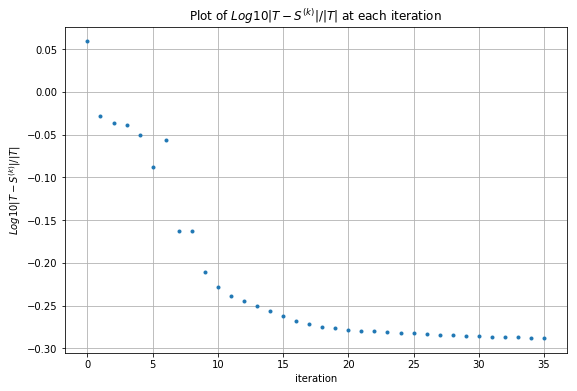

In [4]:
#Here we have some plots about the best computed approximation.
print('\nPlots related to the best approximation\n')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 6

plt.plot(np.log10(step_sizes),'.',markersize=6)
plt.title('Plot of $Log10 \|x^{(k+1)} - x^{(k)} \|$ at each iteration')
plt.xlabel('iteration')
plt.ylabel('$Log10 \|x^{(k+1)} - x^{(k)} \|$')
plt.grid()
plt.show()

plt.plot(np.log10(1/Tsize*errors),'.',markersize=6)
plt.title('Plot of $Log10 \|T - S^{(k)}\|/|T|$ at each iteration')
plt.xlabel('iteration')
plt.ylabel('$Log10 \|T - S^{(k)}\|/|T|$')
plt.grid()
plt.show()

This two plots concenrs only the best trial, i.e., the best run of the function *gauss_newton*. As we can see, the distance between the points $x^{(k)}$ decreases as we make more steps. The steps got so small that the size got smaller than *tol* and the computation stopped.

This trial made $36$ steps, i.e., the *gauss-newton* function in this run made $36$ iterations before stopping. This number of steps is totally reasonable. Furthermore, the second plot shows we attained convergence, so would be wasteful to continue computing. Notice how the program didn't wast time making more useless steps, it stopped at the right moment.

General information


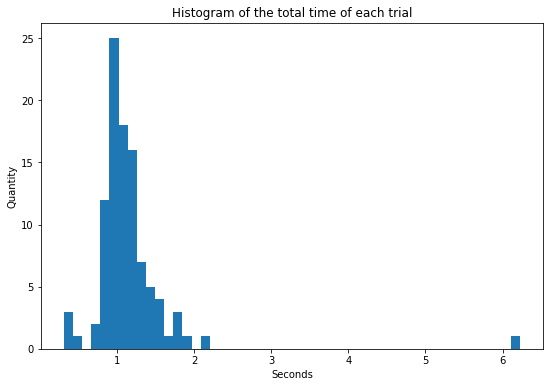

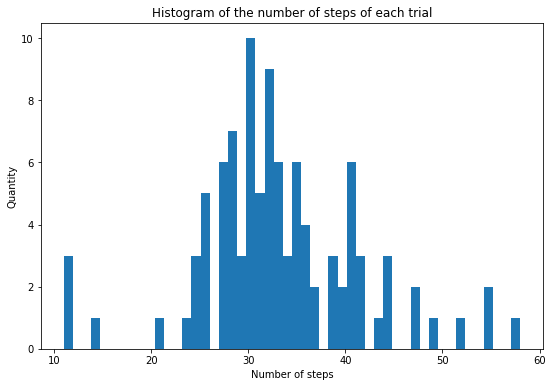

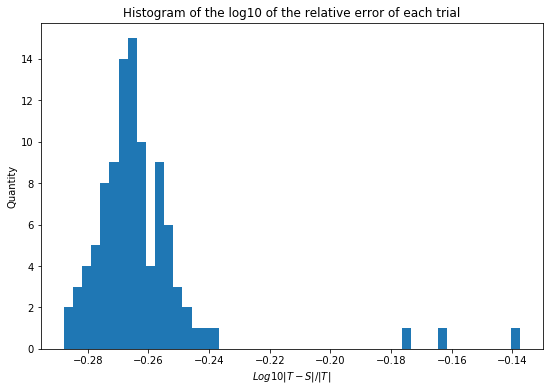

In [5]:
#Here we have some histograms about all trials.
print('General information')

[array,bins,patches] = plt.hist(times, 50)
plt.xlabel('Seconds')
plt.ylabel('Quantity')
plt.title('Histogram of the total time of each trial')
plt.show()

[array,bins,patches] = plt.hist(steps, 50)
plt.xlabel('Number of steps')
plt.ylabel('Quantity')
plt.title('Histogram of the number of steps of each trial')
plt.show()

[array,bins,patches] = plt.hist(np.log10(rel_errors), 50)
plt.xlabel('$Log10\|T-S\|/\|T\|$')
plt.ylabel('Quantity')
plt.title('Histogram of the log10 of the relative error of each trial')
plt.show()

Above we can see some histograms with global information about the trials. Altought the time and number of steps have a distribution more spreaded, the error are more concentrated. This phenomenon was observed in general, and indicates we don't need to make so many trials to get a acceptable approximations $S$. Indeed, we can make only one trial and have a big confidence that the relative error will be close enough to the optimal.

In [6]:
#Maybe not so relevant, but we can plot the path of each coordinate of x during the best computed solution.
m = xpath.shape[0]
for i in range(0,r+3*r*n):
    plt.plot(1,xpath[0,i],'ro')
    plt.plot(range(1,m+1),xpath[:,i])
    text = i+1,'th coordinate of x_i'
    plt.title(text)
    plt.xlabel('Iteration')
    plt.ylabel('$x_i$')
    plt.show()

We will omit this output, but it can be relevant to actually see the path made by the coordinates of $x$ in the best trial. Since $x$ has $r+3rn = 620$ coordinates, it can take a while to make all plots. I used this when I was suspicious of coordinates going to zero or $\pm \infty$.

# Making only one trial may be enough

As we noted above, the distribution of the errors are very concentrated, so we can save computation time making only one trial. In this case it is not necessary to call *low_rank* since what this function does is to call the actual solver several times. The solver is the function *gauss_newton*.

Note that we need to supply and initial point to start the iterations. The function *low_rank* did that by generating random initial points, so we do the same.

In [7]:
#Generate a random point to start the Gauss-Newton method.
L = np.random.randn(r)
X = np.random.randn(r*n)
Y = np.random.randn(r*n)
Z = np.random.randn(r*n)

In [8]:
#Gauss-Newton method.
start = time.time()
[x,S,step_sizes,errors,xpath] = gn.gauss_newton(T,L,X,Y,Z,r,n,maxit) 

#After the computations ends we can print some useful information.
print('Total time =',time.time() - start,'seconds')
print('Total of steps =',step_sizes.shape[0])
Ssize = np.linalg.norm(S)
print('|T| =',Tsize)
print('|S| =',Ssize)
print('|T-S| =',errors[-1])
print('|T-S|/|T| =',errors[-1]/Tsize)

Total time = 0.8158862590789795 seconds
Total of steps = 23
|T| = 36.9453976687
|S| = 31.4479631379
|T-S| = 19.3526250585
|T-S|/|T| = 0.523816937418


The difference of time is huge, while the difference in precision is very small as we can see. Previously we made $100$ trials and obtained a relative error of $\|T-S\|/\|T\| \approx 0.515$ in $117$ seconds. Now we made only one trial and got $\|T-S\|/\|T\| \approx 0.523$ in $0.81$ seconds. A huge difference in time and a little difference in error, this is a win-win situation.

If one is very much concerned about the precision, one idea is to decrease *tol* instead of making several trials. Still with the same point $(\Lambda,X,Y,Z)$, let's decrease *tol* to see what happens.

In [9]:
#Decreasing the parameter tol.
tol = 10**(-6)

#Gauss-Newton method.
start = time.time()
[x,S,step_sizes,errors,xpath] = gn.gauss_newton(T,L,X,Y,Z,r,n,maxit,tol) 

#After the computations ends we can print some useful information.
print('Total time =',time.time() - start,'seconds')
print('Total of steps =',step_sizes.shape[0])
Ssize = np.linalg.norm(S)
print('|T| =',Tsize)
print('|S| =',Ssize)
print('|T-S| =',errors[-1])
print('|T-S|/|T| =',errors[-1]/Tsize)

Total time = 1.9079961776733398 seconds
Total of steps = 100
|T| = 36.9453976687
|S| = 31.582204974
|T-S| = 19.1578652474
|T-S|/|T| = 0.518545379297


We've got a solution almost as nice as the previous one just decreasing *tol*, and it took only $1.9$ seconds!

The alert reader will note that this result is actually still a little worse of that we got using *low_rank*. Using *low_rank* we got $0.515349819336$, which is slightly smaller than $0.518545379297$. If precision really matters, using *low_rank* with low tolerance is the solution. Otherwise, use *gauss_newton* with the default tolerance. The default tolerance is *tol *$= 0.001$. This value was choosed because it gives the best balance between speed and precision. Of course this was determined experimentally, so the user is free to change it at will.

It is important to remember that decreasing the tolerance will give better solutions with a high cost. The computation time increases fast as we decrease *tol*. Below we show this by computing the same problem with *tol *$= 10^{-t}$ for $t = 0,1,2,3,4,5,6$. This effect gets amplified as $n$ and $r$ increases.

In [10]:
timing_tol = np.zeros(7)
errors_tol = np.zeros(7)
for t in range(0,7):
    tol = 10**(-t)
    start = time.time()
    [x,S,step_sizes,errors,xpath] = gn.gauss_newton(T,L,X,Y,Z,r,n,maxit,tol) 
    timing_tol[t] = time.time() - start
    errors_tol[t] = errors[-1]/Tsize

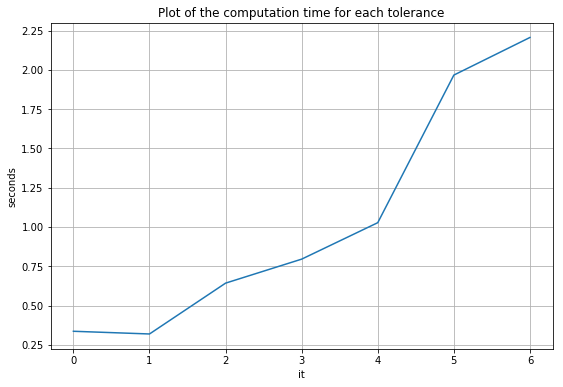

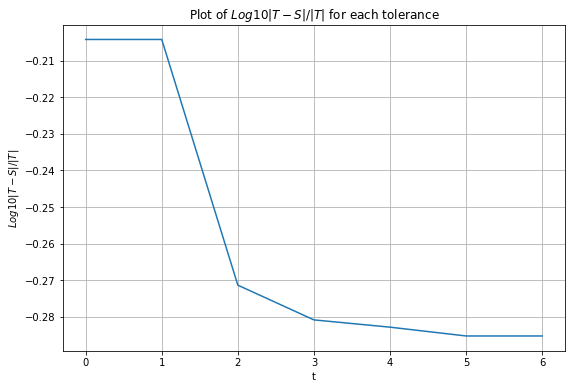

In [11]:
plt.plot(timing_tol)
plt.title('Plot of the computation time for each tolerance')
plt.xlabel('it')
plt.ylabel('seconds')
plt.grid()
plt.show()

plt.plot(np.log10(errors_tol))
plt.title('Plot of $Log10 \|T - S\|/|T|$ for each tolerance')
plt.xlabel('t')
plt.ylabel('$Log10 \|T - S\|/|T|$')
plt.grid()
plt.show()

# Timing of Gauss-Newton 

At this moment I still want to make the function *gauss_newton* even faster. Going back a litle in my history, I started implementing Gauss-Newton with line search, but this approach was beaten by the damped Gauss-Newton. The damp parameter is used just as in the original paper of Marquardt (1963) - *An Algorithm for Least Squares Estimation on Nonlinear
Parameters*. There are new strategies to updating the damp parameter, but this only affects the number of steps, which already is small. The main cost of *gauss_newton* is the function scipy.sparse.linalg.lsmr, which is based on an article of D. C.-L. Fong and M. A. Saunders, *LSMR: An iterative algorithm for sparse least-squares problems*. 

The function *gauss_newton_timing* runs exactly as *gauss_newton*, but it measures the computation time of the relevant parts. Besides the function lsmr, the second costly part is the creation of the sparse matrix $D\textbf{res}$, but this cost is low compared to lsmr. These two parts are measured in *gauss_newton_timing* and we also measure the time of the rest of all computations.   

In [12]:
#Tolerance choice.
tol = 10**(-4)

#Gauss-Newton method with timing.
start = time.time()
[x,S,step_sizes,errors,xpath,sparse_time,gauss_newton_time,rest_time] = gn.gauss_newton_timing(T,L,X,Y,Z,r,n,maxit,tol) 

#After the computations ends we can print some useful information.
print('Total time =',time.time() - start,'seconds')
print('Total of steps =',step_sizes.shape[0])
Ssize = np.linalg.norm(S)
print('|T| =',Tsize)
print('|S| =',Ssize)
print('|T-S| =',errors[-1])
print('|T-S|/|T| =',errors[-1]/Tsize)

Total time = 1.163522720336914 seconds
Total of steps = 35
|T| = 36.9453976687
|S| = 31.5164881431
|T-S| = 19.2643038677
|T-S|/|T| = 0.521426350324


Mean(gauss_newton_time) = 0.0294799055372 seconds
Mean(sparse_time) = 0.00257264545986 seconds
Mean(rest_time) = 0.00100725037711 seconds


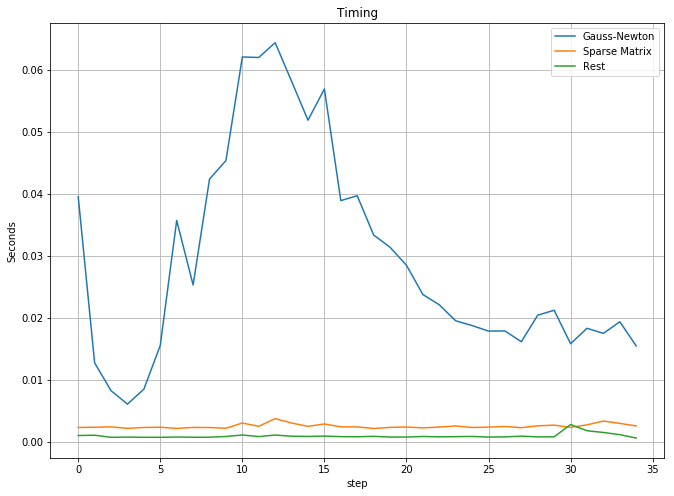

In [13]:
#Timing means.
print('Mean(gauss_newton_time) =',np.mean(gauss_newton_time),'seconds')
print('Mean(sparse_time) =',np.mean(sparse_time),'seconds')
print('Mean(rest_time) =',np.mean(rest_time),'seconds')

#Timings plots.
m = rest_time.shape[0]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 11
fig_size[1] = 8
plt.plot(range(0,m),gauss_newton_time,label='Gauss-Newton')
plt.plot(range(0,m),sparse_time,label='Sparse Matrix')
plt.plot(range(0,m),rest_time,label='Rest')
plt.title('Timing')
plt.xlabel('step')
plt.ylabel('Seconds')
plt.legend()
plt.savefig('timing.png')
plt.grid()
plt.show()
fig_size[0] = 9
fig_size[1] = 6

What I called "Gauss-Newton" in the figure is the time to compute the function lsmr. Clearly this is the most costly part. If we want to improve this algorithm, we need to change this part specifically. This can be a hard task since lsmr is a new algorithm which is proven to be very fast.

# Extras

The function lsmr works over the matrix $D\textbf{res}$, which is supposed to be sparse. To see that this is indeed the case (and, therefore, we are using lsmr in the best way possible) we can begin plotting the matrix to see how is it sparse structure. 

Percentage of sparsity = 87.9765395894


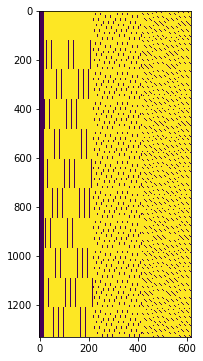

In [14]:
[data,row,col] = gn.initialize(r,n)
Dr = sparse.csr_matrix((data, (row, col)), shape=((n+1)**3,r+3*r*n))
A = (Dr.toarray() == 0)
print('Percentage of sparsity =',100*(1-np.sum(Dr)/A.size))
plt.imshow(A)
plt.show()

The yellow part are the zeros of the matrix, while the purple parts are the nonzero entries. The percentage of sparsity gets bigger as we increase $n$ (and it doesn't depend on $r$). Therefore sparsity is not the problem here. Probably we achieved the most of lsmr and it doesn't gets better than that. 

The user may notice that we use the decorator jit almost in every function. Not only that, but we use *nogil = True*, *parallel = True* and *prange*. This means the user can get a boost by running this program in a cluster or a computer with lots od CPUs. The function lsmr works on parallel, so use and abuse of parallelism. Unfortunately, the creation of a sparse csr matrix doesn't make use of parallelism, so with enough CPUs the bottleneck will be the sparse matrix creation. This is a problem for the future.

Finally, there is one more relevant function in this module, called *rank*. It tries to estimate the rank of a tensor $T$ (which is denoted by $R(T)$), although it depends on the border rank of $T$. In some cases the output is in fact the border rank of $T$, not the rank. This function is an experiment and shouldn't be taken so seriously. Below we give an example.

R(T) = 52
|T-S|/|T| = 0.000318020904269


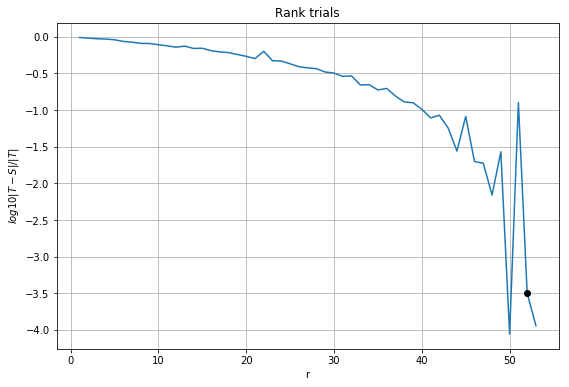

In [18]:
#Computation of the rank of T, with a plot together.
[r,rank_errors] = gn.rank(T)

This is the same tensor $T$ since the beggining. We can note that, for $r = 20$, we have the graph close to $-0.27$, and this agrees with the best approximation we computed before for $T$, because $log_{10}0.51 \approx -0.29$. Therefore, the best approximation for $T$ with rank $r = 20$ has a relative error of $\approx 0.51$. 

After the marked point the graph continues horizontally, which means all approximations are about the same, so we pick the first point where this happened and say this is the rank of $T$.

Since $T \in \mathbb{R}^{n+1} \otimes \mathbb{R}^{n+1} \otimes \mathbb{R}^{n+1}$, we have that $1 \leq R(T) \leq (n+1)^2$ (this is a theorem about tensors). In our particular case we have that $1 \leq R(T) \leq 121$ because $n = 10$.